In [32]:
import pandas as pd
import numpy as np

import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

In [3]:
tbl = pd.read_csv('CLEAR_DATA.csv')
print(tbl.shape)
tbl.head()

(188523, 4)


,text,topic,topic_name,text_len
0,Фото: Кирилл Шипицин / РИА Новости Марина Сови...,0,Россия,709
1,Фото: Pixabay Марина Совина Терапевт Ирина Анд...,0,Россия,1183
2,Фото: Илья Наймушин/ РИА Новости Марина Совина...,0,Россия,1115
3,Фото: Валерий Мельников / РИА Новости Марина С...,0,Россия,713
4,Леонид Пасечник Фото: Alexei Nikolsky / Global...,0,Россия,941


# Предобработка текстов

In [2]:
# nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))

In [18]:
def preprocess_string(text):
    '''
    1. Приведем тексты к нижнему регистру
    2. Удалим цифры и спецсимволы
    3. Удалим стоп-слова
    4. Проведем стемминг (хотелось бы лемматизацию, но ее нет в nltk для русского языка)
    '''
    global stop_words
    text = re.sub(r'\d+', '', text)  # -digits
    text = re.sub(r'[^\w\s]', '', text).replace('  ', ' ')  # -symbols
    text = text.lower()
    words = text.split()
    words = [word for word in words if word not in stop_words]

    stemmer = SnowballStemmer("russian")
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_words = [word for word in stemmed_words if len(word) > 3] # оставим только слова в которых больше 3 букв
    
    return ' '.join(stemmed_words)

In [6]:
tbl['text_clear'] = tbl['text'].apply(preprocess_string)

In [7]:
tbl.head()

,text,topic,topic_name,text_len,text_clear
0,Фото: Кирилл Шипицин / РИА Новости Марина Сови...,0,Россия,709,кирилл шипицин новост марин совин ярославл веч...
1,Фото: Pixabay Марина Совина Терапевт Ирина Анд...,0,Россия,1183,pixabay марин совин терапевт ирин андреев бесе...
2,Фото: Илья Наймушин/ РИА Новости Марина Совина...,0,Россия,1115,наймушин новост марин совин доцент экономическ...
3,Фото: Валерий Мельников / РИА Новости Марина С...,0,Россия,713,валер мельник новост марин совин человек получ...
4,Леонид Пасечник Фото: Alexei Nikolsky / Global...,0,Россия,941,леонид пасечник alexei nikolsky globallookpres...


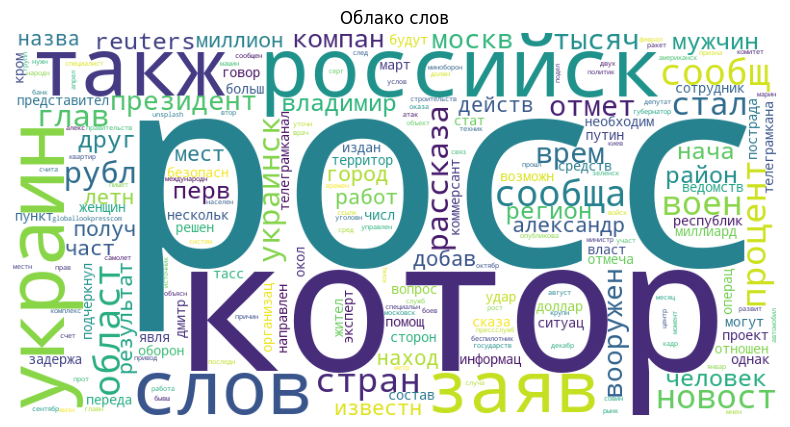

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

word_freq = {}
for row in tbl.text_clear:
    listed_row = row.split(' ')
    for elem in listed_row:
        if elem not in word_freq:
            word_freq[elem] = 0
        word_freq[elem] += 1

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Облако слов')
plt.show()

In [9]:
tbl.to_csv('TRANSFORMED_DATA.csv', index=False)

# Обучение моделей (бейзлайн)

In [3]:
tbl = pd.read_csv('TRANSFORMED_DATA.csv')

In [4]:
# разобьем данные на трейн и тест для дальнейшего сравнения моделей
X = tbl['text_clear']
y = tbl['topic']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [5]:
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)#.toarray()
X_test_vectorized = vectorizer.transform(X_test)#.toarray()

```
Здесь и далее для создании векторов (эмбедингов) использую TF-IDF. 

TF-IDF (Term Frequency-Inverse Document Frequency) — это метод, используемый для оценки значимости слова в документе относительно всего корпуса текста. TF (частота термина) измеряет, как часто слово встречается в отдельном тексте, тогда как IDF (обратная частота документа) отражает, насколько редко слово встречается в различных текстах корпуса. Эта методика помогает улучшить текстовый поиск, подчеркивая слова, которые наиболее информативны и релевантны в контексте данного текста.
```

In [ ]:
# бейзлайн лог регресии
lr = LogisticRegression(max_iter=1_000)  #  c дефолтным кол-вом итераций лог регрессия не сходится
lr.fit(X_train_vectorized, y_train)
pred = lr.predict(X_test_vectorized)
accuracy_score(y_test, pred)

0.9405699009144725

In [15]:
# бейзлайн случайного леса
rf = RandomForestClassifier()
rf.fit(X_train_vectorized, y_train)
pred = rf.predict(X_test_vectorized)
accuracy_score(y_test, pred)

0.9126052916339564

In [ ]:
# бейзлайн бустинга
model = LGBMClassifier(n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train_vectorized, y_train)
pred = model.predict(X_test_vectorized)
accuracy_score(y_test, pred)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.203445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1534540
[LightGBM] [Info] Number of data points in the train set: 141392, number of used features: 23243
[LightGBM] [Info] Start training from score -1.268675
[LightGBM] [Info] Start training from score -1.856728
[LightGBM] [Info] Start training from score -2.116090
[LightGBM] [Info] Start training from score -1.709764
[LightGBM] [Info] Start training from score -2.700034
[LightGBM] [Info] Start training from score -3.228234
[LightGBM] [Info] Start training from score -3.330961
[LightGBM] [Info] Start training from score -2.938502
[LightGBM] [Info] Start training from score -2.723136


0.9415671214275105

### Подбор гиперпараметров

In [24]:
params = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'dual': [True, False],
    'tol': [1e-4, 1e-3, 1e-2],
    'C': [0, 0.1, 0.5, 1, 10, 100, 1_000, 10_000],
    'fit_intercept': [True, False],
    'class_weight': ['balanced', None]
}

setka = GridSearchCV(LogisticRegression(max_iter=1_000), params, n_jobs=-1, verbose=True, cv=3, scoring='accuracy', refit='accuracy')
setka.fit(X_train_vectorized, y_train)
setka.best_params_, setka.best_score_

Fitting 3 folds for each of 768 candidates, totalling 2304 fits


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

({'C': 10,
  'class_weight': None,
  'dual': False,
  'fit_intercept': True,
  'penalty': 'l2',
  'tol': 0.0001},
 np.float64(0.9435187336218323))

In [27]:
pred = setka.best_estimator_.predict(X_test_vectorized)
accuracy_score(y_test, pred)

0.9423309499055823

`Очень хороший результат на тесте. Теперь предскажем тематики для файла к Каггла. Для этого выполним те же преобразования над текстами, токенизацию, а после предскажем Лог регрессией.`

In [56]:
test_news = pd.read_csv('kaggle_data/test_news.csv').rename(columns={'content': 'text'})
test_news.head()

,text
0,Фото: «Фонтанка.ру»ПоделитьсяЭкс-министру обор...
1,В начале февраля 2023 года в Пушкинском районе...
2,Фото: Andy Bao / Getty Images Анастасия Борисо...
3,"Если вы хотели, но так и не съездили на море л..."
4,Сергей Пиняев Фото: Алексей Филиппов / РИА Нов...


In [55]:
test_news['text_clear'] = test_news['text'].apply(preprocess_string)

In [39]:
test_news_vectorized = vectorizer.transform(test_news['text_clear'])

In [42]:
pred = setka.best_estimator_.predict(test_news_vectorized)
pred

array([0, 6, 4, ..., 3, 3, 3])

In [46]:
result = pd.DataFrame(pred).reset_index()
result.columns = ['index', 'topic']
result = result[['topic', 'index']]

In [ ]:
result.to_csv('test_news_result.csv', index=False)  # (try № 1)

`А что если обучить модель на всем датасете `

In [ ]:
vectorizer2 = TfidfVectorizer()
X_vectorized = vectorizer2.fit_transform(X)#.toarray()
test_news_vectorized = vectorizer2.transform(test_news['text_clear'])

In [59]:
pred = LogisticRegression(
    max_iter=1000, C=10, class_weight=None, dual=False, fit_intercept=True, penalty='l2', tol=0.0001
    ).fit(X_vectorized, y).predict(test_news_vectorized)

In [ ]:
result = pd.DataFrame(pred).reset_index()
result.columns = ['index', 'topic']
result = result[['topic', 'index']]
result.to_csv('test_news_result2.csv', index=False)  # (try № 2)

`Обучение на всем датасете дало прирост в точности 0.1`

`Теперь попробуем затюнить модель бустинга`

In [ ]:
# все параметры сразу будут перебираться часами, поэтому решил подбирать по одному параметру за раз, чтобы видеть прогресс
params = {
    'learning_rate': [0.01, 0.1, 1, 10]
}
gb = LGBMClassifier(n_jobs=-1, verbose=-1, random_state=42)
setka = GridSearchCV(gb, params, n_jobs=-1, verbose=2, cv=3, scoring='accuracy', refit='accuracy')
setka.fit(X_train_vectorized, y_train)
setka.best_params_, setka.best_score_

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ...................................learning_rate=10; total time= 3.3min
[CV] END ...................................learning_rate=10; total time= 3.4min
[CV] END ...................................learning_rate=10; total time= 3.4min
[CV] END ....................................learning_rate=1; total time= 4.2min
[CV] END ....................................learning_rate=1; total time= 4.4min
[CV] END ....................................learning_rate=1; total time= 4.5min
[CV] END .................................learning_rate=0.01; total time= 7.2min
[CV] END .................................learning_rate=0.01; total time= 7.3min
[CV] END .................................learning_rate=0.01; total time= 7.3min
[CV] END ..................................learning_rate=0.1; total time= 7.5min
[CV] END ..................................learning_rate=0.1; total time= 7.5min
[CV] END ..................................learni

({'learning_rate': 0.1}, np.float64(0.9435328757424447))

In [47]:
params = {
    'n_estimators': [100, 500, 1000]
    # 'max_depth': [-1, 3, 5, 10],
    # 'num_leaves': [31, 20, 40]
}
gb = LGBMClassifier(learning_rate=0.1, n_jobs=-1, verbose=-1, random_state=42)
setka = GridSearchCV(gb, params, n_jobs=-1, verbose=2, cv=3, scoring='accuracy', refit='accuracy')
setka.fit(X_train_vectorized, y_train)
setka.best_params_, setka.best_score_

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ...................................n_estimators=100; total time= 8.2min
[CV] END ...................................n_estimators=100; total time= 8.2min
[CV] END ...................................n_estimators=100; total time= 8.5min
[CV] END ...................................n_estimators=500; total time=27.4min
[CV] END ...................................n_estimators=500; total time=27.6min
[CV] END ...................................n_estimators=500; total time=27.6min
[CV] END ..................................n_estimators=1000; total time=37.2min
[CV] END ..................................n_estimators=1000; total time=37.8min
[CV] END ..................................n_estimators=1000; total time=38.0min


({'n_estimators': 1000}, np.float64(0.9495586793553817))

In [49]:
params = {
    'max_depth': [-1, 3, 5, 10]
    # 'num_leaves': [31, 20, 40]
}
gb = LGBMClassifier(learning_rate=0.1, n_estimators=1000, n_jobs=-1, verbose=-1, random_state=42)
setka = GridSearchCV(gb, params, n_jobs=-1, verbose=2, cv=3, scoring='accuracy', refit='accuracy')
setka.fit(X_train_vectorized, y_train)
setka.best_params_, setka.best_score_

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ........................................max_depth=3; total time=33.4min
[CV] END ........................................max_depth=3; total time=33.4min
[CV] END ........................................max_depth=3; total time=34.1min
[CV] END ........................................max_depth=5; total time=46.0min
[CV] END ........................................max_depth=5; total time=46.1min
[CV] END ........................................max_depth=5; total time=46.1min
[CV] END .......................................max_depth=10; total time=58.0min
[CV] END .......................................max_depth=10; total time=59.0min
[CV] END .......................................max_depth=10; total time=59.2min
[CV] END .......................................max_depth=-1; total time=62.9min
[CV] END .......................................max_depth=-1; total time=63.8min
[CV] END .......................................m

({'max_depth': -1}, np.float64(0.9495586793553817))

In [13]:
params = {
    'num_leaves': [31, 40, 50, 100]  # 31 - default value
}
gb = LGBMClassifier(learning_rate=0.1, n_estimators=1000, n_jobs=-1, max_depth=-1, verbose=-1, random_state=42)
setka = GridSearchCV(gb, params, n_jobs=-1, verbose=2, cv=3, scoring='accuracy', refit='accuracy')
setka.fit(X_train_vectorized, y_train)
setka.best_params_, setka.best_score_

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ......................................num_leaves=31; total time=85.0min
[CV] END ......................................num_leaves=31; total time=86.2min
[CV] END ......................................num_leaves=31; total time=86.3min
[CV] END ......................................num_leaves=40; total time=96.3min
[CV] END ......................................num_leaves=40; total time=96.6min
[CV] END ......................................num_leaves=40; total time=96.8min
[CV] END .....................................num_leaves=50; total time=101.9min
[CV] END .....................................num_leaves=50; total time=102.4min
[CV] END .....................................num_leaves=50; total time=103.5min
[CV] END ....................................num_leaves=100; total time=107.1min
[CV] END ....................................num_leaves=100; total time=107.2min
[CV] END ....................................num_

({'num_leaves': 50}, 0.9501881337525305)

In [14]:
pred = setka.best_estimator_.predict(X_test_vectorized)
accuracy_score(y_test, pred)  # отличный результат на тесте

0.950266279094439

In [16]:
# обучим на всем датасете
vectorizer2 = TfidfVectorizer()
X_vectorized = vectorizer2.fit_transform(X)#.toarray()

gb_model = LGBMClassifier(learning_rate=0.1,  n_estimators=1000, num_leaves=50, n_jobs=-1, max_depth=-1, verbose=-1, random_state=42)
gb_model.fit(X_vectorized, y)

LGBMClassifier(n_estimators=1000, n_jobs=-1, num_leaves=50, random_state=42,
               verbose=-1)

In [19]:
# предскажем на каггл-датасете
test_news = pd.read_csv('kaggle_data/test_news.csv').rename(columns={'content': 'text'})
test_news['text_clear'] = test_news['text'].apply(preprocess_string)
test_news_vectorized = vectorizer2.transform(test_news['text_clear'])

In [20]:
pred = gb_model.predict(test_news_vectorized)
result = pd.DataFrame(pred).reset_index()
result.columns = ['index', 'topic']
result = result[['topic', 'index']]
result

,topic,index
0,0,0
1,6,1
2,4,2
3,0,3
4,4,4
...,...,...
26270,3,26270
26271,3,26271
26272,3,26272
26273,3,26273


In [21]:
# result.to_csv('test_news_result3.csv', index=False)  # (try № 3) тут я некорректно затюнил, но отправил попытку на кагл
result.to_csv('test_news_result6.csv', index=False)  # (try № 6) тут корректно :)

## Хочу попробовать не TF-IDF, а CountVectorizer. И без стемминга

In [ ]:
tbl = pd.read_csv('CLEAR_DATA.csv')

def preprocess_string_2(text):
    '''
    1. Приведем тексты к нижнему регистру
    2. Удалим цифры и спецсимволы
    3. Удалим стоп-слова
    '''
    global stop_words
    text = re.sub(r'\d+', '', text)  # -digits
    text = re.sub(r'[^\w\s]', '', text).replace('  ', ' ')  # -symbols
    text = text.lower()
    words = text.split()
    words = [word for word in words if word not in stop_words]
    
    return ' '.join(words)

tbl['text_clear'] = tbl['text'].apply(preprocess_string_2)

In [ ]:
X = tbl['text_clear']
y = tbl['topic']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [73]:
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)#.toarray()
X_test_vectorized = vectorizer.transform(X_test)#.toarray()

In [74]:
# бейзлайн лог регресии
lr = LogisticRegression(max_iter=1_000)  #  c дефолтным кол-вом итераций лог регрессия не сходится
lr.fit(X_train_vectorized, y_train)
pred = lr.predict(X_test_vectorized)
accuracy_score(y_test, pred)

0.9444102607625554

In [79]:
params = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'dual': [True, False],
    'tol': [1e-4, 1e-3, 1e-2],
    'C': [0, 0.1, 0.5, 1, 10, 100, 1_000, 10_000],
    'fit_intercept': [True, False],
    'class_weight': ['balanced', None]
}

setka = GridSearchCV(LogisticRegression(max_iter=1_000, verbose=False, random_state=42), params, n_jobs=-1, verbose=1, cv=3, scoring='accuracy', refit='accuracy')
setka.fit(X_train_vectorized, y_train)
setka.best_params_, setka.best_score_

Fitting 3 folds for each of 768 candidates, totalling 2304 fits


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

({'C': 0.1,
  'class_weight': 'balanced',
  'dual': False,
  'fit_intercept': True,
  'penalty': 'l2',
  'tol': 0.0001},
 np.float64(0.945569766390178))

In [80]:
pred = setka.best_estimator_.predict(X_test_vectorized)
accuracy_score(y_test, pred)

0.9461925272113896

In [81]:
test_news = pd.read_csv('kaggle_data/test_news.csv').rename(columns={'content': 'text'})
test_news['text_clear'] = test_news['text'].apply(preprocess_string_2)
test_news_vectorized = vectorizer.transform(test_news['text_clear'])

In [82]:
pred = setka.best_estimator_.predict(test_news_vectorized)
result = pd.DataFrame(pred).reset_index()
result.columns = ['index', 'topic']
result = result[['topic', 'index']]
result

,topic,index
0,2,0
1,6,1
2,4,2
3,6,3
4,4,4
...,...,...
26270,3,26270
26271,3,26271
26272,3,26272
26273,3,26273


In [ ]:
result.to_csv('test_news_result4.csv', index=False)  # (try № 4) - скор на каггле упал до 0.79 :(

# Попробуем создать эмбединги на предобученной модели (из библиотеки Gensim)

`P.S. я не настоящий сварщик в NLP`

In [62]:
tbl = pd.read_csv('CLEAR_DATA.csv')
tbl['text_clear'] = tbl['text'].apply(preprocess_string_2)

In [63]:
X = tbl['text_clear']
y = tbl['topic']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [ ]:
import gensim.downloader
# print(list(gensim.downloader.info()['models'].keys()))  # список всех доступных моделей
model_name = 'fasttext-wiki-news-subwords-300'
fasttext = gensim.downloader.load(model_name)
fasttext

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
def get_vector(text, model):
    words = text.split()
    word_vectors = [model[word] for word in words if word in model]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.vector_size)

In [ ]:
X_train_emb = np.array([get_vector(text, fasttext) for text in X_train])
X_test_emb = np.array([get_vector(text, fasttext) for text in X_test])

In [76]:
# бейзлайн лог регресии
lr = LogisticRegression(max_iter=1_000)
lr.fit(X_train_emb, y_train)
pred = lr.predict(X_test_emb)
accuracy_score(y_test, pred)

0.5892512359169124

`Ну чет все совсем плохо`

# Попробуем SGD

In [22]:
from sklearn.linear_model import SGDClassifier

model = SGDClassifier()
model.fit(X_train_vectorized, y_train)

pred = model.predict(X_test_vectorized)
accuracy_score(y_test, pred)

0.9317858734166472

Из коробки сразу точность 0.93, попробуем затюнить

In [39]:

params = {
    'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    # 'loss': ['log_loss', 'squared_error'],
    # 'penalty': ['l2', 'l1', 'elasticnet', None],
    # 'alpha': [0.0001, 0.01, 0.1, 1, 100],
    # 'l1_ratio': [0.15, 0.5, 0.75],
    # 'learning_rate': ['constant', 'optimal'],
    # learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    # power_t -  for inverse scaling
    # 'eta0': [0, 0.01, 0.1]

}

setka = GridSearchCV(SGDClassifier(verbose=False, max_iter=10_000, n_jobs=-1), params, n_jobs=-1, verbose=2, cv=3, scoring='accuracy', refit='accuracy')
setka.fit(X_train_vectorized, y_train)
setka.best_params_, setka.best_score_

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .........................................loss=hinge; total time=   2.2s
[CV] END ......................................loss=log_loss; total time=   2.6s
[CV] END ......................................loss=log_loss; total time=   2.7s
[CV] END ................................loss=modified_huber; total time=   3.2s
[CV] END ....................................loss=perceptron; total time=   2.2s
[CV] END ....................................loss=perceptron; total time=   2.4s
[CV] END .........................................loss=hinge; total time=   2.7s
[CV] END ....................................loss=perceptron; total time=   2.5s
[CV] END .........................................loss=hinge; total time=   2.9s
[CV] END ......................................loss=log_loss; total time=   3.6s
[CV] END ................................loss=modified_huber; total time=   4.1s
[CV] END ................................loss=mod

/Users/dlyapin/Documents/git_projects/hse_ml_2024/venv/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END ...................loss=squared_epsilon_insensitive; total time=25.3min


/Users/dlyapin/Documents/git_projects/hse_ml_2024/venv/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END ...................loss=squared_epsilon_insensitive; total time=25.3min


/Users/dlyapin/Documents/git_projects/hse_ml_2024/venv/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END ...................loss=squared_epsilon_insensitive; total time=25.3min


({'loss': 'modified_huber'}, 0.9412060157235572)

In [42]:

params = {
    'penalty': ['l2', 'l1', 'elasticnet', None],
    'alpha': [0.0001, 0.01, 0.1, 1, 100],
    # 'l1_ratio': [0.15, 0.5, 0.75],
    # 'learning_rate': ['constant', 'optimal'],
    # learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    # power_t -  for inverse scaling
    # 'eta0': [0, 0.01, 0.1]

}

setka = GridSearchCV(SGDClassifier(loss='modified_huber', verbose=False, max_iter=10_000, n_jobs=-1), params, n_jobs=-1, verbose=2, cv=3, scoring='accuracy', refit='accuracy')
setka.fit(X_train_vectorized, y_train)
setka.best_params_, setka.best_score_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END ...........................alpha=0.0001, penalty=l2; total time=   4.5s
[CV] END ...........................alpha=0.0001, penalty=l2; total time=   5.0s
[CV] END ...........................alpha=0.0001, penalty=l2; total time=   5.8s
[CV] END ...........................alpha=0.0001, penalty=l1; total time=   7.3s
[CV] END ...........................alpha=0.0001, penalty=l1; total time=   7.3s
[CV] END ...........................alpha=0.0001, penalty=l1; total time=   7.3s
[CV] END .............................alpha=0.01, penalty=l2; total time=   2.8s
[CV] END .............................alpha=0.01, penalty=l2; total time=   2.7s
[CV] END ...................alpha=0.0001, penalty=elasticnet; total time=   7.8s
[CV] END ...................alpha=0.0001, penalty=elasticnet; total time=   8.1s
[CV] END .............................alpha=0.01, penalty=l2; total time=   2.8s
[CV] END ...................alpha=0.0001, penalt

({'alpha': 0.0001, 'penalty': 'l2'}, 0.9413121022618616)

In [ ]:

params = {
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0, 0.01, 0.1]

}

setka = GridSearchCV(SGDClassifier(loss='modified_huber', penalty='l2', alpha=0.0001, verbose=False, max_iter=10_000, n_jobs=-1), params, n_jobs=-1, verbose=2, cv=3, scoring='accuracy', refit='accuracy')
setka.fit(X_train_vectorized, y_train)
setka.best_params_, setka.best_score_

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END .....................eta0=0, learning_rate=constant; total time=   0.0s
[CV] END .....................eta0=0, learning_rate=constant; total time=   0.0s
[CV] END .....................eta0=0, learning_rate=constant; total time=   0.0s
[CV] END ...................eta0=0, learning_rate=invscaling; total time=   0.0s
[CV] END ...................eta0=0, learning_rate=invscaling; total time=   0.0s
[CV] END ...................eta0=0, learning_rate=invscaling; total time=   0.0s
[CV] END .....................eta0=0, learning_rate=adaptive; total time=   0.1s
[CV] END .....................eta0=0, learning_rate=adaptive; total time=   0.1s
[CV] END .....................eta0=0, learning_rate=adaptive; total time=   0.1s
[CV] END ......................eta0=0, learning_rate=optimal; total time=   4.4s
[CV] END ......................eta0=0, learning_rate=optimal; total time=   4.5s
[CV] END ......................eta0=0, learning_

({'eta0': 0, 'learning_rate': 'optimal'}, 0.9413616119141683)

In [47]:
model = SGDClassifier(loss='modified_huber', max_iter=10_000, n_jobs=-1, penalty='l2', alpha=0.0001, learning_rate='optimal')
model.fit(X_train_vectorized, y_train)

pred = model.predict(X_test_vectorized)
accuracy_score(y_test, pred)

0.9411852071884746

In [48]:
# на всем датасете обучим

model = SGDClassifier(loss='modified_huber', max_iter=10_000, n_jobs=-1, penalty='l2', alpha=0.0001, learning_rate='optimal')
model.fit(X_vectorized, y)

SGDClassifier(loss='modified_huber', max_iter=10000, n_jobs=-1)

In [49]:
# предскажем на каггл-датасете
test_news = pd.read_csv('kaggle_data/test_news.csv').rename(columns={'content': 'text'})
test_news['text_clear'] = test_news['text'].apply(preprocess_string)
test_news_vectorized = vectorizer2.transform(test_news['text_clear'])

In [50]:
pred = model.predict(test_news_vectorized)
result = pd.DataFrame(pred).reset_index()
result.columns = ['index', 'topic']
result = result[['topic', 'index']]
result

,topic,index
0,0,0
1,6,1
2,4,2
3,0,3
4,4,4
...,...,...
26270,3,26270
26271,3,26271
26272,3,26272
26273,3,26273


In [51]:
result.to_csv('test_news_result7.csv', index=False)  # (try № 7) 

```
Итоги:

1. Наилучший результат показала модель градиентного спуска с подбором гиперпараметров (accuracy_score на каггле - 0.84286)
2. Следующая по качеству модель - логистическая регрессия с подбором гиперпараметров (accuracy_score на каггле - 0.83)
3. Наилучший результат получается при предварительной обработки текстов с помощью стемминга, а также создании эмбедингов с помощью TF-IDF.
4. При использовании CountVectorizer вместо TF-IDF качество падает.
5. Использование стемминга повышает качество прогнозирования.
```